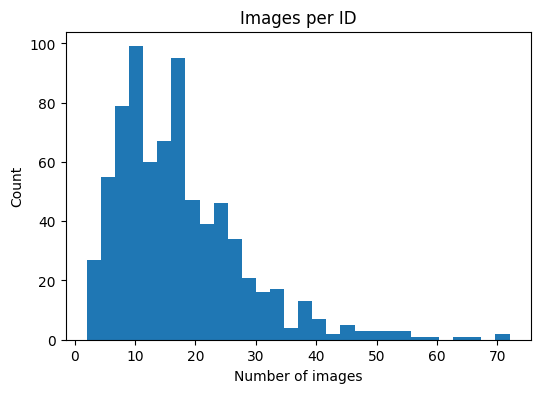

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


Epoch 01 — Loss 0.4446, R1 54.28%, mAP 8.11%
Epoch 02 — Loss 0.3798, R1 45.28%, mAP 7.14%
Epoch 03 — Loss 0.3507, R1 50.48%, mAP 8.27%
Epoch 04 — Loss 0.3365, R1 50.92%, mAP 9.12%
Epoch 05 — Loss 0.3299, R1 56.00%, mAP 10.64%
Epoch 06 — Loss 0.3234, R1 58.52%, mAP 12.14%
Epoch 07 — Loss 0.3183, R1 61.97%, mAP 13.60%
Epoch 08 — Loss 0.3143, R1 65.65%, mAP 15.93%
Epoch 09 — Loss 0.3126, R1 68.53%, mAP 17.26%
Epoch 10 — Loss 0.3103, R1 72.03%, mAP 20.00%
Epoch 11 — Loss 0.3080, R1 73.81%, mAP 22.40%
Epoch 12 — Loss 0.3061, R1 76.66%, mAP 24.53%
Epoch 13 — Loss 0.3047, R1 79.19%, mAP 26.58%
Epoch 14 — Loss 0.3036, R1 80.82%, mAP 29.01%
Epoch 15 — Loss 0.3019, R1 81.24%, mAP 31.60%
Epoch 16 — Loss 0.2997, R1 82.57%, mAP 34.33%
Epoch 17 — Loss 0.2997, R1 84.65%, mAP 36.69%
Epoch 18 — Loss 0.2984, R1 84.03%, mAP 38.87%
Epoch 19 — Loss 0.2977, R1 85.21%, mAP 40.79%
Epoch 20 — Loss 0.2967, R1 85.75%, mAP 42.90%
Epoch 21 — Loss 0.2952, R1 86.82%, mAP 45.83%
Epoch 22 — Loss 0.2938, R1 86.49%, mAP

<Figure size 640x480 with 0 Axes>

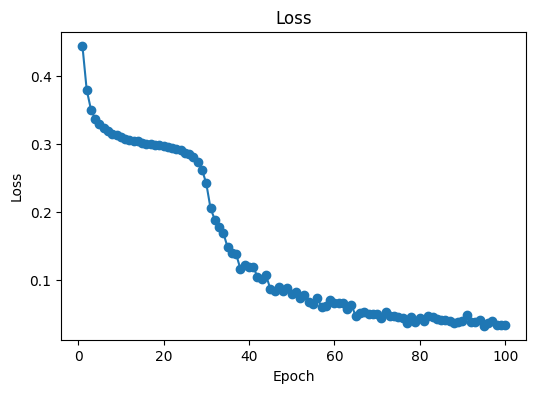

<Figure size 640x480 with 0 Axes>

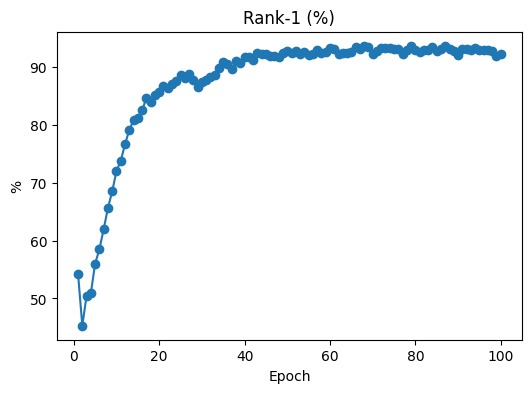

<Figure size 640x480 with 0 Axes>

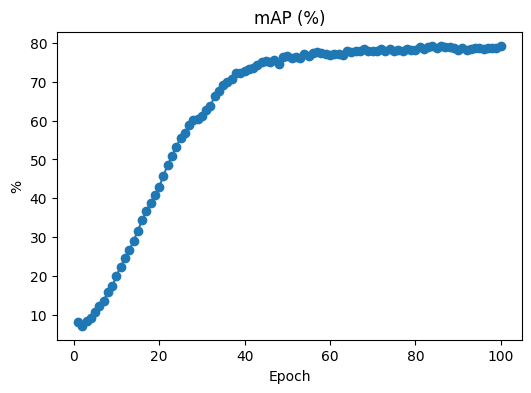

<Figure size 640x480 with 0 Axes>

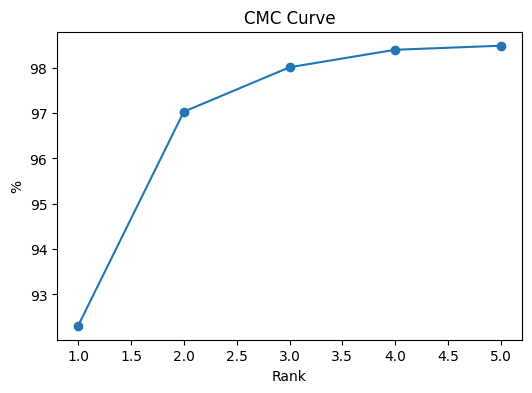

Final R1 92.31%, R5 98.49%, R10 99.11%, mAP 79.23%


<Figure size 640x480 with 0 Axes>

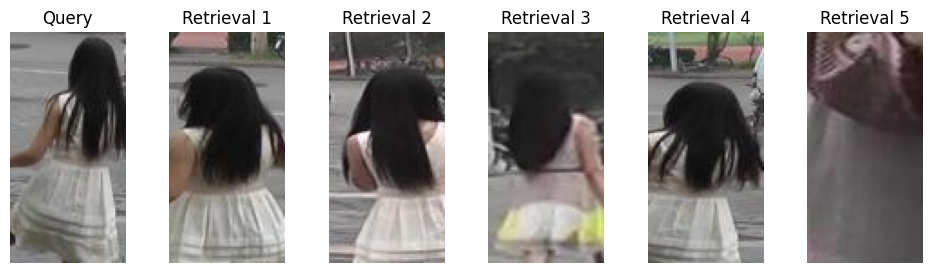

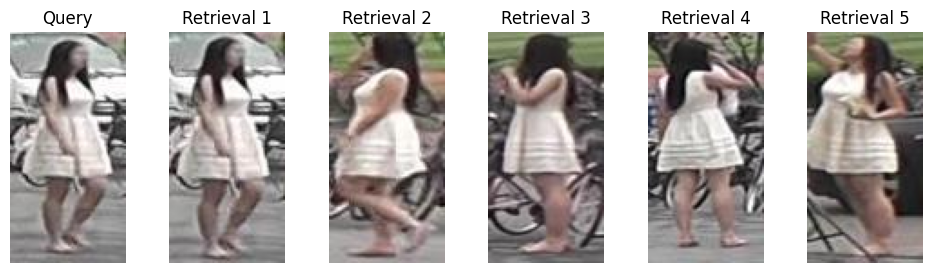

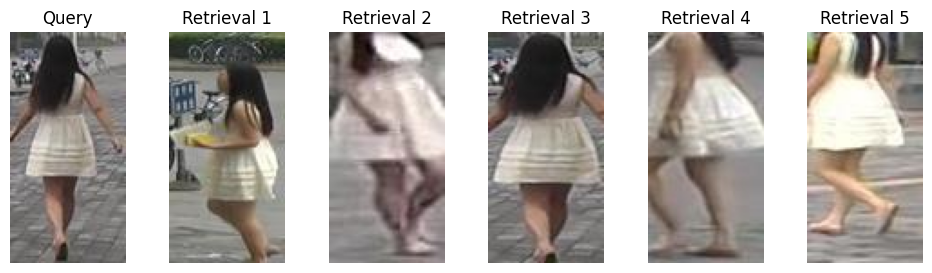

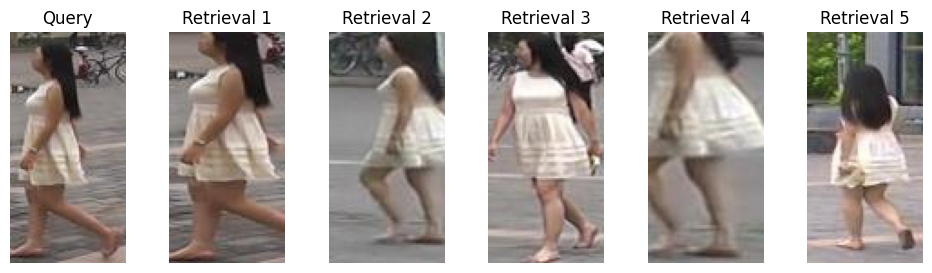

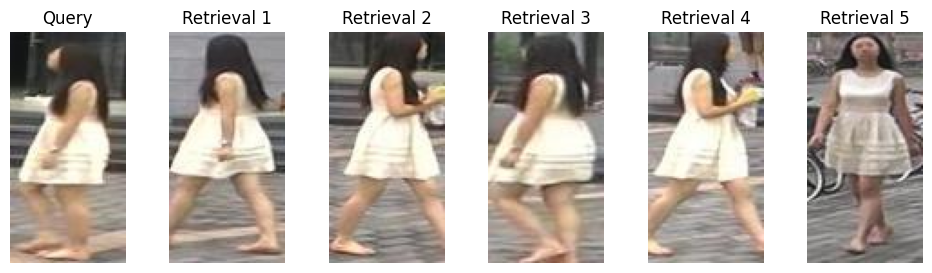

In [3]:
import os
from pathlib import Path
import argparse

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import torchvision.transforms as T
import torchvision.models as models

from re_ranking import re_ranking

TRAIN_DIR   = '/kaggle/input/dataset/Market-1501/bounding_box_train'
QUERY_DIR   = '/kaggle/input/dataset/Market-1501/query'
GALLERY_DIR = '/kaggle/input/dataset/Market-1501/bounding_box_test'
SAVE_DIR    = 'logs'

P = 16; K = 4
EMBEDDING_DIM = 128
MARGIN = 0.3
LR = 1e-4
EPOCHS = 100
TOPK = 5


class RandomIdentitySampler(Sampler):
    def __init__(self, data_source, num_identities, num_instances):
        self.data_source = data_source
        self.num_id = num_identities
        self.num_ins = num_instances
        self.pid_to_idxs = {}
        for idx, (_, pid) in enumerate(data_source.samples):
            self.pid_to_idxs.setdefault(pid, []).append(idx)
        self.pids = list(self.pid_to_idxs.keys())

    def __iter__(self):
        np.random.shuffle(self.pids)
        batch = []
        for pid in self.pids:
            idxs = self.pid_to_idxs[pid]
            chosen = (
                np.random.choice(idxs, self.num_ins, replace=True)
                if len(idxs) < self.num_ins
                else np.random.choice(idxs, self.num_ins, replace=False)
            )
            batch.extend(chosen.tolist())
            if len(batch) >= self.num_id * self.num_ins:
                yield from batch[: self.num_id * self.num_ins]
                batch = batch[self.num_id * self.num_ins :]

    def __len__(self):
        return len(self.pids) * self.num_ins


class ImageReIDDataset(Dataset):
    def __init__(self, root_dir, transform=None, return_paths=False):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.return_paths = return_paths
        self.samples = []
        for pid_dir in sorted(self.root_dir.iterdir()):
            if not pid_dir.is_dir():
                continue
            pid = int(pid_dir.name)
            for img_file in pid_dir.glob('*.*'):
                self.samples.append((img_file, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, pid = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.return_paths:
            return img, pid, str(path)
        else:
            return img, pid


def collate_with_paths(batch):
    imgs, pids, paths = zip(*batch)
    imgs = torch.stack(imgs, 0)
    pids = torch.tensor(pids, dtype=torch.long)
    paths = list(paths)
    return imgs, pids, paths


class ReIDNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        self.proj = nn.Linear(backbone.fc.in_features, embedding_dim)

    def forward(self, x):
        x = self.features(x).view(x.size(0), -1)
        x = self.proj(x)
        return F.normalize(x, p=2, dim=1)


def batch_hard_triplet_loss(embeddings, labels, margin):
    dist = torch.cdist(embeddings, embeddings, p=2)
    N = dist.size(0)
    labels = labels.unsqueeze(1)
    is_pos = (labels == labels.t()) & ~torch.eye(N, device=embeddings.device).bool()
    is_neg = labels != labels.t()

    hardest_pos = (dist * is_pos.float()).max(dim=1)[0]
    max_dist = dist.max().item()
    dist_neg = dist + max_dist * (~is_neg).float()
    hardest_neg = dist_neg.min(dim=1)[0]

    return F.relu(hardest_pos - hardest_neg + margin).mean()


def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for imgs, pids in loader:
        imgs, pids = imgs.to(device), pids.to(device)
        optimizer.zero_grad()
        embeds = model(imgs)
        loss = batch_hard_triplet_loss(embeds, pids, MARGIN)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def extract_features(model, loader, device):
    model.eval()
    feats, pids, paths = [], [], []
    for batch in loader:
        if len(batch) == 3:
            imgs, lbls, img_paths = batch
        else:
            imgs, lbls = batch
            img_paths = [None] * len(lbls)
        embeds = model(imgs.to(device)).cpu()
        feats.append(embeds)
        pids.extend(lbls.numpy())
        paths.extend(img_paths)
    return torch.cat(feats), np.array(pids), paths


@torch.no_grad()
def evaluate(model, q_loader, g_loader, device, topk=TOPK):
    q_feats, q_pids, q_paths = extract_features(model, q_loader, device)
    g_feats, g_pids, g_paths = extract_features(model, g_loader, device)

    q_q = torch.cdist(q_feats, q_feats).numpy()
    q_g = torch.cdist(q_feats, g_feats).numpy()
    g_g = torch.cdist(g_feats, g_feats).numpy()
    dist_rerank = re_ranking(q_g, q_q, g_g)

    cmc, all_AP = [], []
    retrievals = [] 
    for i in range(len(q_feats)):
        indices = np.argsort(dist_rerank[i])
        matches = (g_pids[indices] == q_pids[i])
        # CMC/AP computation
        valid = matches
        cmc_i = valid.cumsum(); cmc_i[cmc_i > 1] = 1
        precision = valid.cumsum() / (np.arange(len(valid)) + 1)
        ap_i = (precision * valid).sum() / valid.sum() if valid.sum() > 0 else 0
        cmc.append(cmc_i)
        all_AP.append(ap_i)
        topk_idxs = indices[:topk]
        imgs = [Image.open(g_paths[j]).convert('RGB') for j in topk_idxs]
        retrievals.append(imgs)

    cmc_curve = np.mean(cmc, axis=0)
    mAP = np.mean(all_AP) * 100
    return cmc_curve, mAP, retrievals, q_paths


def display_retrievals(retrievals, query_paths, topk=TOPK):
    num_show = min(5, len(retrievals))
    for i in range(num_show):
        query_img = Image.open(query_paths[i]).convert('RGB')
        plt.figure(figsize=(12, 3))
        plt.subplot(1, topk + 1, 1)
        plt.imshow(query_img)
        plt.title('Query')
        plt.axis('off')
        for j, img in enumerate(retrievals[i]):
            plt.subplot(1, topk + 1, j + 2)
            plt.imshow(img)
            plt.title(f'Retrieval {j+1}')
            plt.axis('off')
        plt.show()


def plot_pid_dist(dataset):
    counts = {}
    for _, pid in dataset.samples:
        counts[pid] = counts.get(pid, 0) + 1
    plt.figure(figsize=(6,4))
    plt.hist(list(counts.values()), bins=30)
    plt.title('Images per ID')
    plt.xlabel('Number of images'); plt.ylabel('Count')
    plt.show(); plt.clf()


def plot_history(history):
    epochs = np.arange(1, len(history['loss'])+1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history['loss'], 'o-'); plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.show(); plt.clf()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history['rank1'], 'o-'); plt.title('Rank-1 (%)'); plt.xlabel('Epoch'); plt.ylabel('%')
    plt.show(); plt.clf()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history['mAP'], 'o-'); plt.title('mAP (%)'); plt.xlabel('Epoch'); plt.ylabel('%')
    plt.show(); plt.clf()


def plot_cmc(cmc_curve):
    ranks = np.arange(1, TOPK+1)
    plt.figure(figsize=(6,4))
    plt.plot(ranks, cmc_curve[:TOPK]*100, 'o-')
    plt.title('CMC Curve'); plt.xlabel('Rank'); plt.ylabel('%')
    plt.show(); plt.clf()


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_dir',   default=TRAIN_DIR)
    parser.add_argument('--query_dir',   default=QUERY_DIR)
    parser.add_argument('--gallery_dir', default=GALLERY_DIR)
    parser.add_argument('--save_dir',    default=SAVE_DIR)
    args, _ = parser.parse_known_args()

    os.makedirs(args.save_dir, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_tf = T.Compose([
        T.Resize((256,128)), T.RandomHorizontalFlip(),
        T.ColorJitter(0.2,0.2,0.2,0.1), T.ToTensor(),
        T.RandomErasing(p=0.5),
    ])
    test_tf = T.Compose([T.Resize((256,128)), T.ToTensor()])

    train_ds = ImageReIDDataset(args.train_dir, transform=train_tf, return_paths=False)
    query_ds = ImageReIDDataset(args.query_dir, transform=test_tf, return_paths=True)
    gallery_ds = ImageReIDDataset(args.gallery_dir, transform=test_tf, return_paths=True)

    train_loader = DataLoader(train_ds, batch_size=P*K,
                              sampler=RandomIdentitySampler(train_ds,P,K),
                              num_workers=4, pin_memory=True)
    query_loader = DataLoader(query_ds, batch_size=64, shuffle=False,
                              num_workers=4, collate_fn=collate_with_paths)
    gallery_loader = DataLoader(gallery_ds, batch_size=64, shuffle=False,
                                num_workers=4, collate_fn=collate_with_paths)

    plot_pid_dist(train_ds)

    model = ReIDNet(EMBEDDING_DIM).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    history = {'loss':[], 'rank1':[], 'mAP':[]}
    for epoch in range(1, EPOCHS+1):
        loss = train_epoch(model, train_loader, optimizer, device)
        cmc, mAP, retrievals, query_paths = evaluate(model, query_loader, gallery_loader, device)
        history['loss'].append(loss)
        history['rank1'].append(cmc[0]*100)
        history['mAP'].append(mAP)
        print(f"Epoch {epoch:02d} — Loss {loss:.4f}, R1 {cmc[0]*100:.2f}%, mAP {mAP:.2f}%")
        torch.save(model.state_dict(), os.path.join(args.save_dir, f"model_{epoch:02d}.pth"))

    plot_history(history)
    plot_cmc(cmc)
    print(f"Final R1 {cmc[0]*100:.2f}%, R5 {cmc[4]*100:.2f}%, R10 {cmc[9]*100:.2f}%, mAP {mAP:.2f}%")

    # Display retrievals
    display_retrievals(retrievals, query_paths, topk=TOPK)

if __name__ == '__main__':
    main()


In [2]:
!wget -O re_ranking.py \
  https://raw.githubusercontent.com/zhunzhong07/person-re-ranking/master/python-version/re_ranking_ranklist.py

--2025-05-20 18:55:31--  https://raw.githubusercontent.com/zhunzhong07/person-re-ranking/master/python-version/re_ranking_ranklist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4250 (4.2K) [text/plain]
Saving to: ‘re_ranking.py’

re_ranking.py       100%[===================>]   4.15K  --.-KB/s    in 0s      

2025-05-20 18:55:31 (47.2 MB/s) - ‘re_ranking.py’ saved [4250/4250]

